In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import entropy
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import os

sys.path.append(os.path.abspath(".."))


SEED = 16
np.random.seed(SEED)

data=np.load("../datasets/labeled/first_batch_multi_labels.npz")
data2=np.load("../datasets/labeled/second_batch_multi_labels.npz")
data3=np.load("../datasets/labeled/third_batch_multi_labels.npz")

X1=data["X"]
y1=data["y"]

X2=data2["X"]
y2=data2["y"]

X3=data3["X"]
y3=data3["y"]

X=np.concatenate((X1,X2,X3),axis=0)
y=np.concatenate((y1,y2,y3),axis=0)

XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
yy.rename(columns={0:"user",1:"label"},inplace=True)

In [2]:
# Merge labels into main dataset
XX = XX.merge(yy, on="user", how="left").sort_values(by=["user", "item"]).reset_index(drop=True)

print(XX.shape)
XX.head()

(524883, 4)


,user,item,rating,label
0,0,9,0,0
1,0,12,10,0
2,0,13,10,0
3,0,15,10,0
4,0,16,1,0


In [3]:
from utils.feature_transformation import aggregate_features

user_features = aggregate_features(XX)
user_features = user_features.merge(yy, on="user", how="left")
print(user_features.shape)
# user_features.to_csv("user_features.csv", index=False)
user_features.head()


(3300, 65)


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,gap_std,gap_max,user_pop_percentile_mean,user_pop_percentile_std,rating_pct_-10,rating_pct_0,rating_pct_1,rating_pct_10,rare_like_ratio,label
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,4.506494,25.0,0.769795,0.202953,0.029762,0.083333,0.291667,0.595238,0.000000,0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,3.486183,21.0,0.767464,0.213025,0.076923,0.283654,0.274038,0.365385,0.999999,0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,4.284194,28.0,0.795246,0.178840,0.266667,0.087179,0.307692,0.338462,0.000000,3
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,9.873591,38.0,0.864354,0.179592,0.170732,0.243902,0.341463,0.243902,0.000000,0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,72.024070,192.0,0.733917,0.206937,0.000000,0.166667,0.166667,0.666667,0.000000,0


In [4]:
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

df = user_features.copy()

# TODO: To achieve the best result, need to select the best features based on SHAP. Just uncomment this code to get the highest AUC so far.
# # SHAP-guided feature filtering
# keep = set([
#     "user", "label",
#     'unknown_pct', 'min_movie', 'z_rating_median',
#        'popularity_vs_deviation', 'gap_mean', 'mean_rating_diff',
#        'std_movie_popularity', 'std_deviation', 'max_movie', 'average_product',
#        'max_abs_rating_diff', 'std_rating', 'likes_rare', 'variance_movie',
#        'avg_rating', 'min_movie_popularity', 'like_dislike_ratio', 'gap_max',
#        'rare_movies_watched_pct', 'rare_like_ratio', 'median_movie',
#        'dislike_pct', 'mean_abs_deviation', 'max_movie_popularity',
#        'user_pop_percentile_std', 'rating_entropy', 'z_rating_max',
#        'max_abs_deviation', 'sum_item_rating'
# ])
# df = df[[col for col in df.columns if col in keep]]

print(df.shape)
df.head()

(3300, 65)


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,gap_std,gap_max,user_pop_percentile_mean,user_pop_percentile_std,rating_pct_-10,rating_pct_0,rating_pct_1,rating_pct_10,rare_like_ratio,label
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,4.506494,25.0,0.769795,0.202953,0.029762,0.083333,0.291667,0.595238,0.000000,0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,3.486183,21.0,0.767464,0.213025,0.076923,0.283654,0.274038,0.365385,0.999999,0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,4.284194,28.0,0.795246,0.178840,0.266667,0.087179,0.307692,0.338462,0.000000,3
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,9.873591,38.0,0.864354,0.179592,0.170732,0.243902,0.341463,0.243902,0.000000,0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,72.024070,192.0,0.733917,0.206937,0.000000,0.166667,0.166667,0.666667,0.000000,0


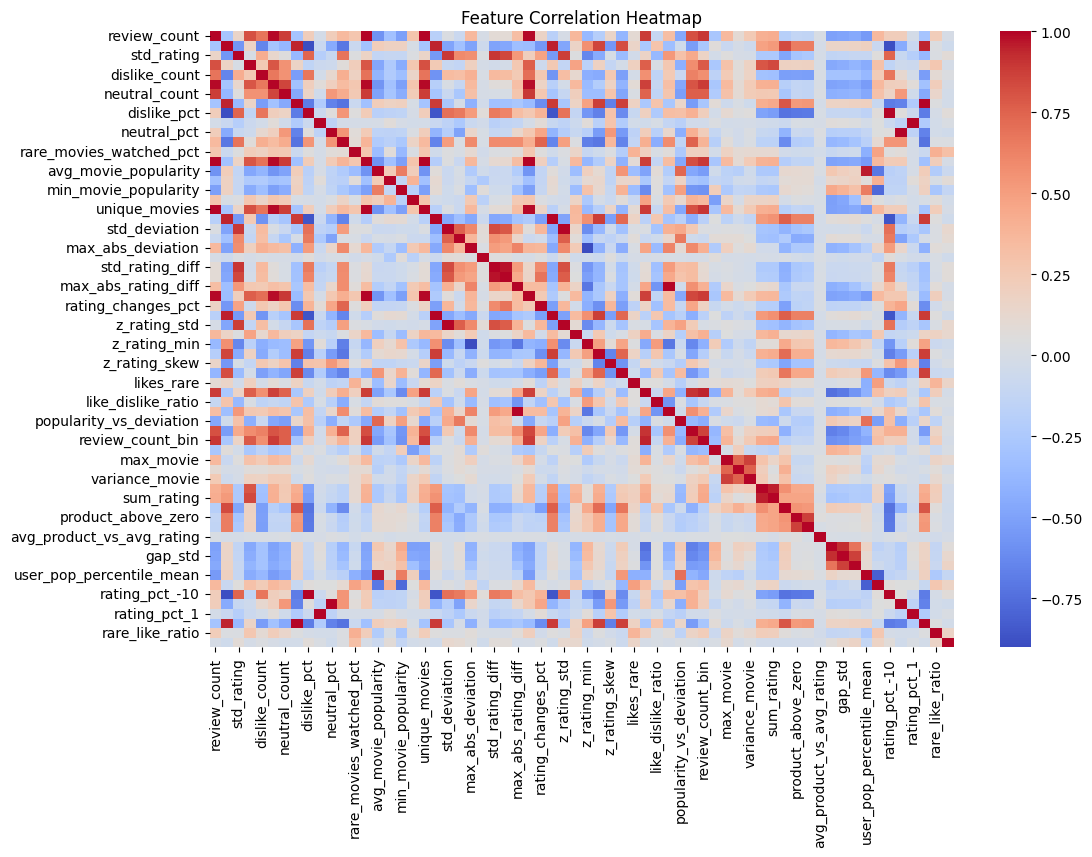

In [5]:
df.drop(columns=["user"], inplace=True)
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
correlated_features = set()
threshold = 0.90

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

df.drop(columns=correlated_features, inplace=True, errors="ignore")
print(f"Dropped correlated features: {correlated_features}")

Dropped correlated features: {'z_rating_min', 'gap_std', 'rating_range', 'z_rating_mean', 'unique_movies', 'like_pct', 'z_rating_std', 'unknown_count', 'sum_rating', 'rating_pct_0', 'mean_deviation', 'rating_changes_count', 'entropy_by_count', 'review_count_bin', 'user_pop_percentile_mean', 'mean_abs_rating_diff', 'change_direction_count', 'rating_pct_-10', 'rating_pct_10', 'rating_pct_1'}


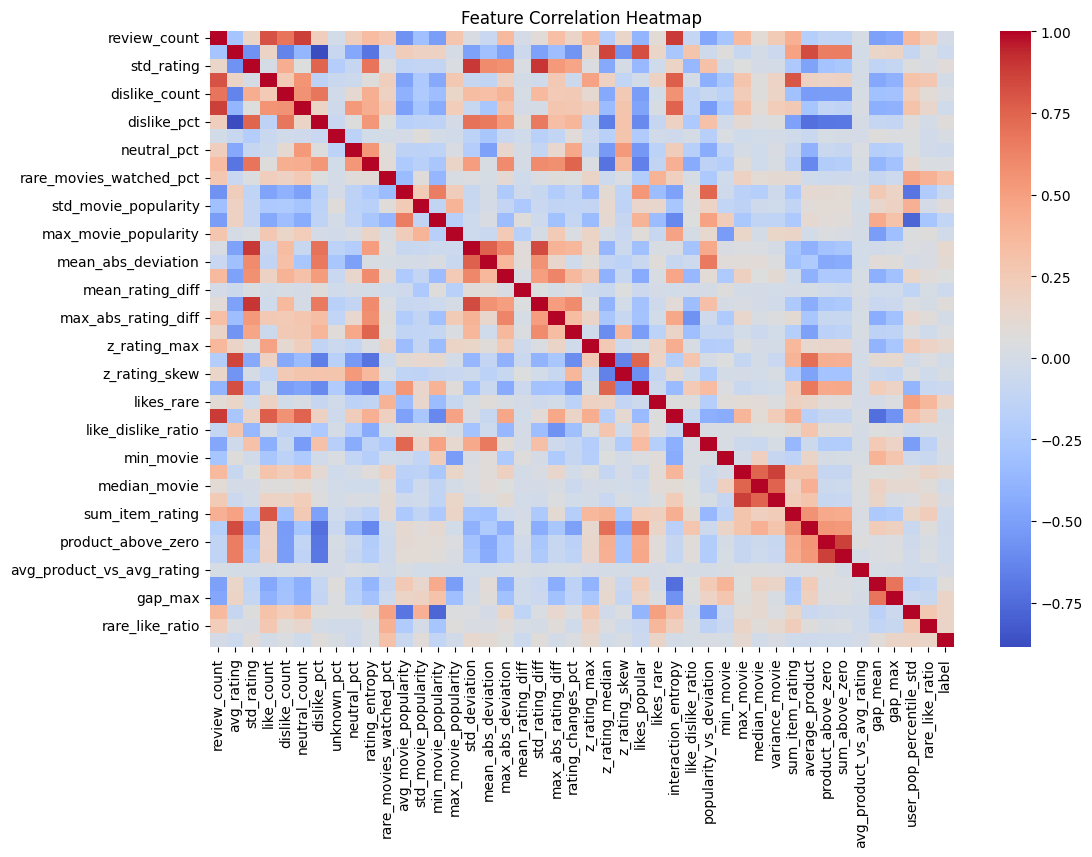

In [7]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
# Define features and target
X = df.drop(columns=["label"])
y = df["label"]

print(X.columns)
X.head()

Index(['review_count', 'avg_rating', 'std_rating', 'like_count',
       'dislike_count', 'neutral_count', 'dislike_pct', 'unknown_pct',
       'neutral_pct', 'rating_entropy', 'rare_movies_watched_pct',
       'avg_movie_popularity', 'std_movie_popularity', 'min_movie_popularity',
       'max_movie_popularity', 'std_deviation', 'mean_abs_deviation',
       'max_abs_deviation', 'mean_rating_diff', 'std_rating_diff',
       'max_abs_rating_diff', 'rating_changes_pct', 'z_rating_max',
       'z_rating_median', 'z_rating_skew', 'likes_popular', 'likes_rare',
       'interaction_entropy', 'like_dislike_ratio', 'popularity_vs_deviation',
       'min_movie', 'max_movie', 'median_movie', 'variance_movie',
       'sum_item_rating', 'average_product', 'product_above_zero',
       'sum_above_zero', 'avg_product_vs_avg_rating', 'gap_mean', 'gap_max',
       'user_pop_percentile_std', 'rare_like_ratio'],
      dtype='object')


,review_count,avg_rating,std_rating,like_count,dislike_count,neutral_count,dislike_pct,unknown_pct,neutral_pct,rating_entropy,...,variance_movie,sum_item_rating,average_product,product_above_zero,sum_above_zero,avg_product_vs_avg_rating,gap_mean,gap_max,user_pop_percentile_std,rare_like_ratio
0,168,5.946429,5.253181,100,5,14,0.029762,0.291667,0.083333,0.979856,...,53415.140576,348353,2073.529762,1,1,348.701643,4.696429,25.0,0.202953,0.000000
1,208,3.158654,5.890205,76,16,59,0.076923,0.274038,0.283654,1.277318,...,40799.608115,234468,1127.250000,1,1,356.876599,3.673077,21.0,0.213025,0.999999
2,195,1.025641,7.750913,66,52,17,0.266667,0.307692,0.087179,1.294501,...,67011.127412,63898,327.682051,1,1,319.489688,4.492308,28.0,0.178840,0.000000
3,41,1.073171,6.455193,10,7,10,0.170732,0.341463,0.243902,1.356990,...,17024.002439,3730,90.975610,1,1,84.772648,10.634146,38.0,0.179592,0.000000
4,6,6.833333,4.915960,4,0,1,0.000000,0.166667,0.166667,0.867563,...,42841.766667,11532,1922.000000,1,1,281.268252,89.666667,192.0,0.206937,0.000000


In [9]:
from imblearn.combine import SMOTETomek

print("🔹 Original Class Distribution:", Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

smote_tomek = SMOTETomek(random_state=SEED)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

class_distribution = Counter(y_train_resampled)
print("🔹 Resampled Class Distribution (After SMOTE):", class_distribution)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

poly = PolynomialFeatures(degree=1, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


🔹 Original Class Distribution: Counter({0: 3000, 3: 60, 4: 60, 2: 60, 5: 60, 1: 60})
🔹 Resampled Class Distribution (After SMOTE): Counter({3: 2363, 5: 2226, 2: 2223, 4: 2149, 1: 2136, 0: 2075})


In [10]:
import optuna
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import json

params_file = "best_xgb_params.json"

if os.path.exists(params_file):
    print("Loading best parameters from file...")
    with open(params_file, "r") as f:
        best_params = json.load(f)
else:
    def objective(trial):
        params = {
            "objective": "multi:softprob",
            "num_class": len(np.unique(y_train_resampled)),
            "eval_metric": "mlogloss",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 9),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 0.2),
            "random_state": SEED,
            "tree_method": "hist",
            "predictor": "cpu_predictor",
            "verbosity": 0,
            "n_jobs": 1
        }

        model = xgb.XGBClassifier(**params)
        model.fit(X_train_poly, y_train_resampled)
        y_pred_proba = model.predict_proba(X_test_poly)

        auc_scores = []
        for i in range(y_pred_proba.shape[1]):
            binary_true = (y_test == i).astype(int)
            try:
                auc = roc_auc_score(binary_true, y_pred_proba[:, i])
                auc_scores.append(auc)
            except:
                auc_scores.append(0)

        return np.mean(auc_scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=60)

    best_params = study.best_params

    with open(params_file, "w") as f:
        json.dump(best_params, f)

    print(best_params)


Loading best parameters from file...


In [11]:
num_classes = len(np.unique(y))
xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    random_state=SEED,
    reg_lambda=0.1,
    n_jobs=1,
    
)

xgb_model.fit(X_train_poly, y_train_resampled)

y_pred_proba_xgb = xgb_model.predict_proba(X_test_poly)

print("XGBoost AUC Scores per Class:")
auc_per_class_xgb = {}
for i in range(y_pred_proba_xgb.shape[1]):
    binary_true = (y_test == i).astype(int)
    try:
        auc = roc_auc_score(binary_true, y_pred_proba_xgb[:, i])
        auc_per_class_xgb[i] = auc
        print(f"  Class {i}: AUC = {auc:.3f}")
    except Exception as e:
        auc_per_class_xgb[i] = None
        print(f"  Class {i}: AUC could not be computed")

k = 5
AUC_0 = auc_per_class_xgb[0]
anomaly_aucs = [auc_per_class_xgb[i] for i in range(1, k+1) if i in auc_per_class_xgb]

final_metric = (0.5 * AUC_0) + (0.5 / k) * sum(anomaly_aucs)

print(f"\nFinal Evaluation Metric: {final_metric:.3f}")

XGBoost AUC Scores per Class:
  Class 0: AUC = 0.900
  Class 1: AUC = 0.909
  Class 2: AUC = 0.976
  Class 3: AUC = 0.988
  Class 4: AUC = 0.815
  Class 5: AUC = 0.814

Final Evaluation Metric: 0.900


In [12]:
# X_full = np.concatenate((X_train, X_test), axis=0)
# y_full = np.concatenate((y_train, y_test), axis=0)

# print("🔹 Original Class Distribution (Full Dataset):", Counter(y_full))

# smote_tomek = SMOTETomek(random_state=SEED)
# X_full_resampled, y_full_resampled = smote_tomek.fit_resample(X_full, y_full)

# print("🔹 Resampled Class Distribution (After SMOTE):", Counter(y_full_resampled))

# scaler = StandardScaler()
# X_full_scaled = scaler.fit_transform(X_full_resampled)

# poly = PolynomialFeatures(degree=1, interaction_only=False, include_bias=False)
# X_full_poly = poly.fit_transform(X_full_scaled)

# xgb_model = xgb.XGBClassifier(
#     **best_params,
#     objective='multi:softprob',
#     num_class=num_classes,
#     eval_metric='auc',
#     random_state=SEED,
#     reg_lambda=0.1,
#     n_jobs=1
# )

# xgb_model.fit(X_full_poly, y_full_resampled)

# print("✅ Model trained on the full dataset.")


In [13]:
import joblib

# Save objects
model_features = list(X_train_resampled.columns)
joblib.dump(model_features, "../testing/model_features.pkl")
joblib.dump(scaler, "../testing/scaler.pkl")
joblib.dump(poly, "../testing/poly.pkl")
joblib.dump(xgb_model, "../testing/xgb_model.pkl")

['../testing/xgb_model.pkl']

 99%|===================| 594/600 [01:03<00:00]        


📊 SHAP Summary for Class 0


C:\Users\juski\AppData\Local\Temp\ipykernel_22404\3266179721.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


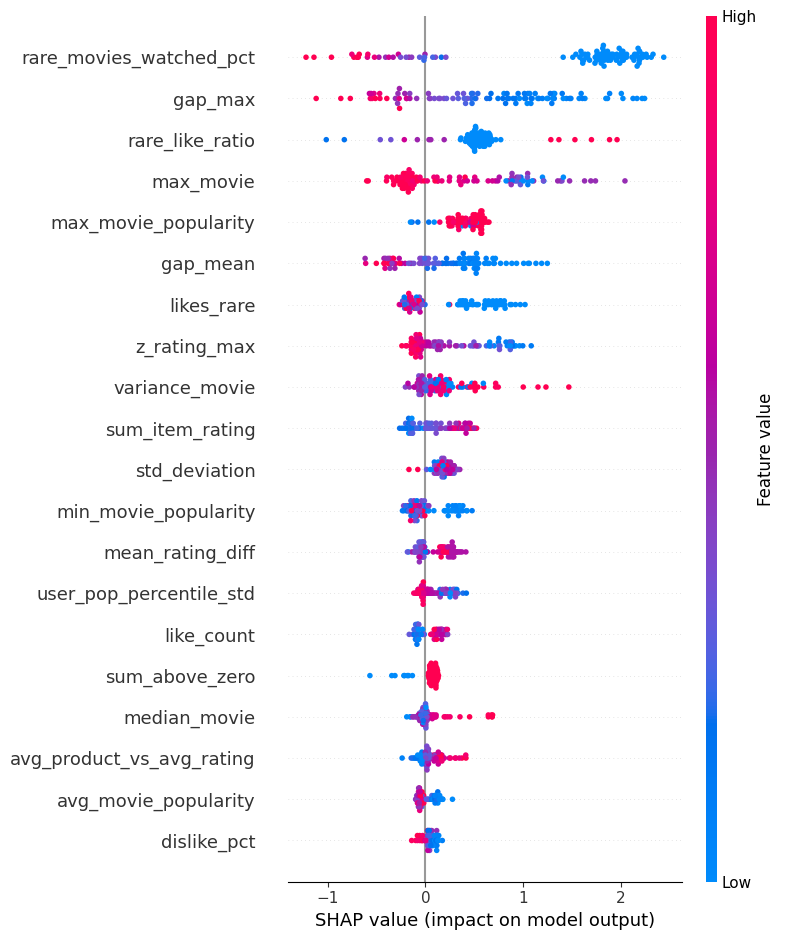


📊 SHAP Summary for Class 1


C:\Users\juski\AppData\Local\Temp\ipykernel_22404\3266179721.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


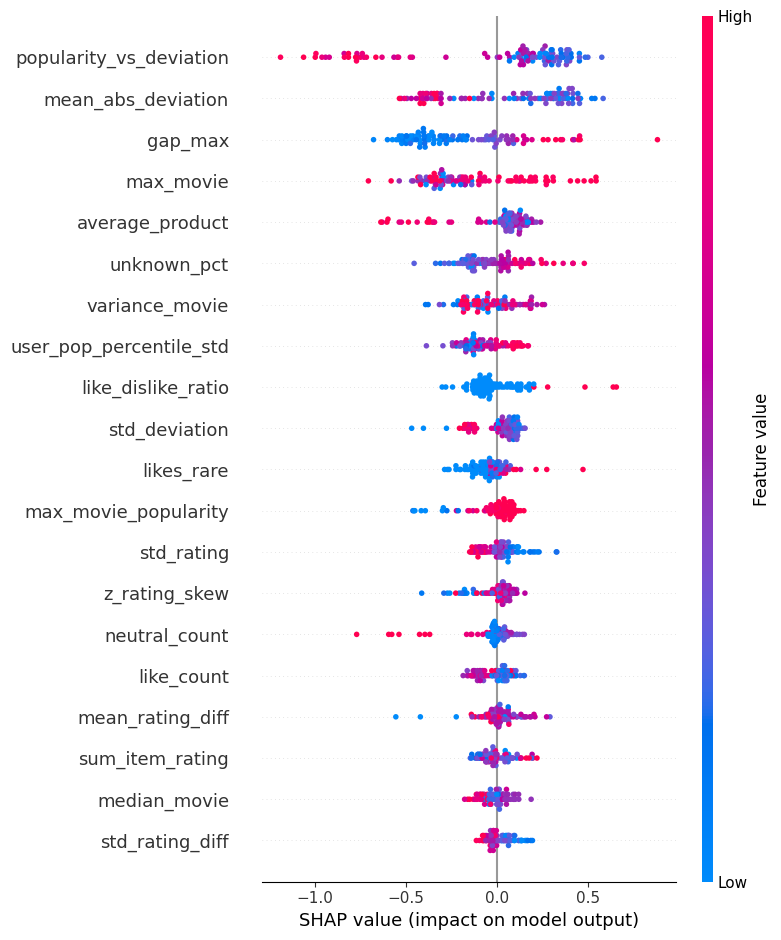


📊 SHAP Summary for Class 2


C:\Users\juski\AppData\Local\Temp\ipykernel_22404\3266179721.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


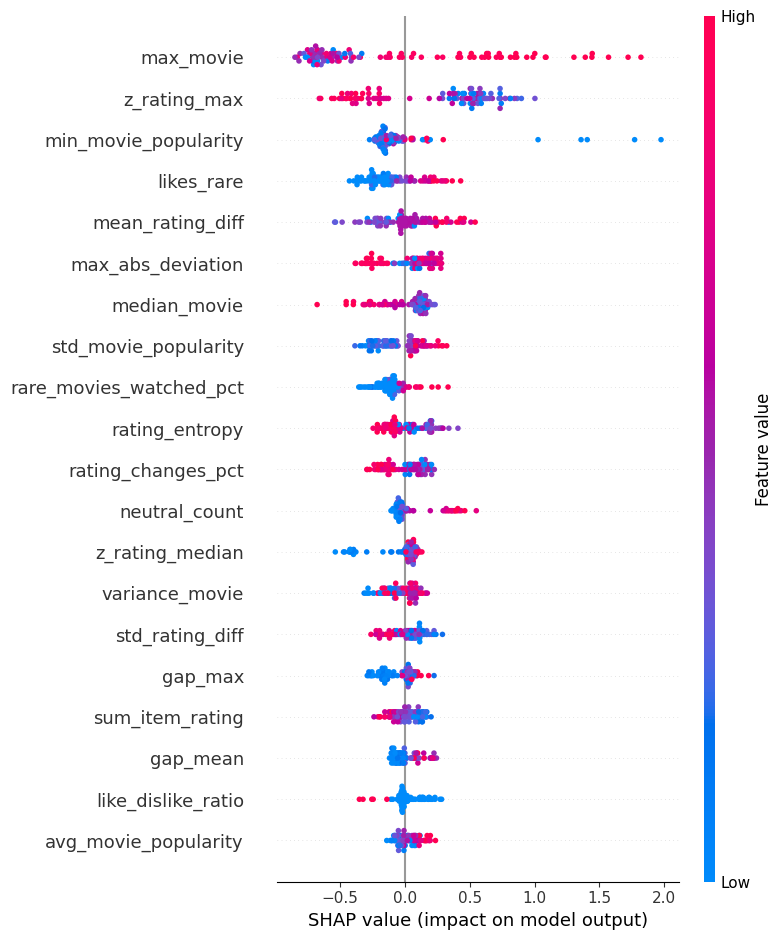


📊 SHAP Summary for Class 3


C:\Users\juski\AppData\Local\Temp\ipykernel_22404\3266179721.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


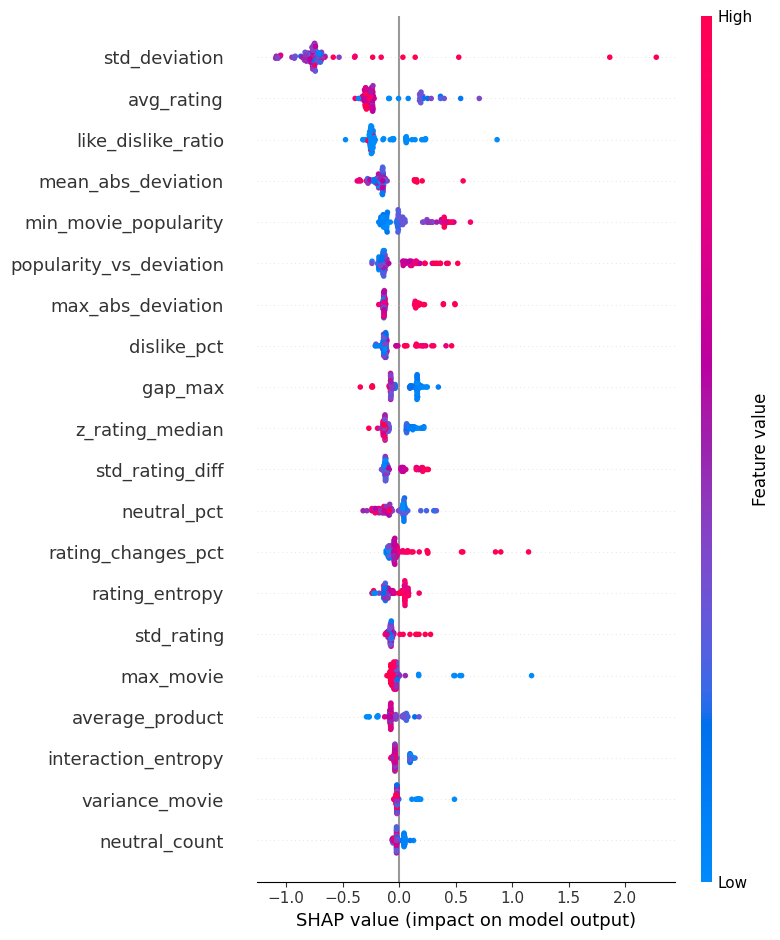


📊 SHAP Summary for Class 4


C:\Users\juski\AppData\Local\Temp\ipykernel_22404\3266179721.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


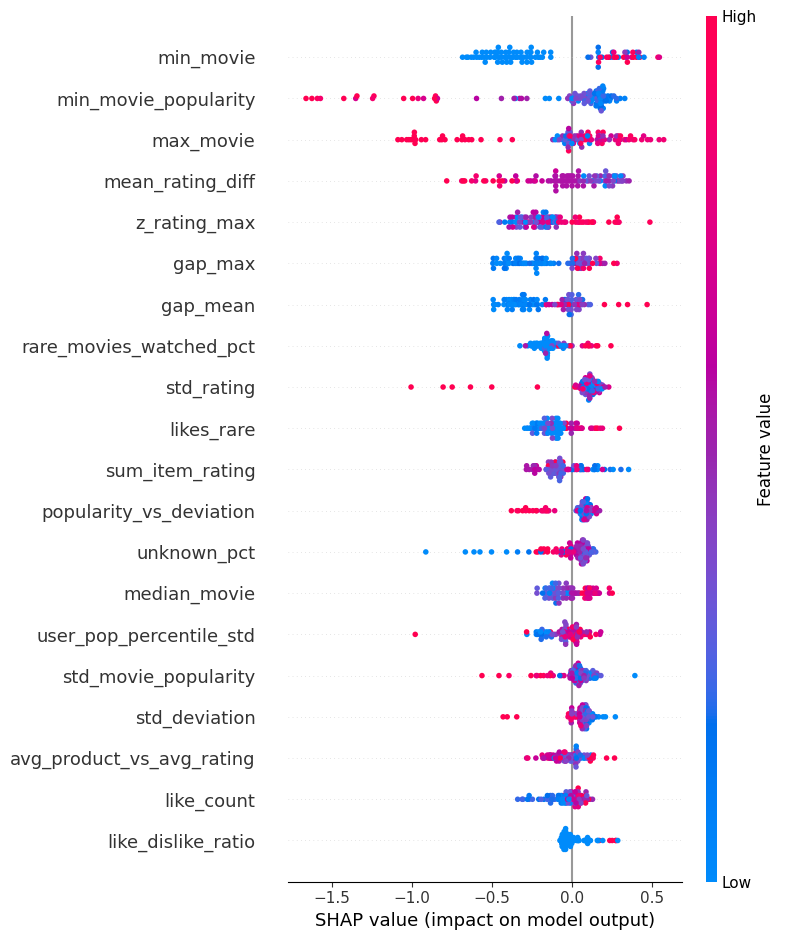


📊 SHAP Summary for Class 5


C:\Users\juski\AppData\Local\Temp\ipykernel_22404\3266179721.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


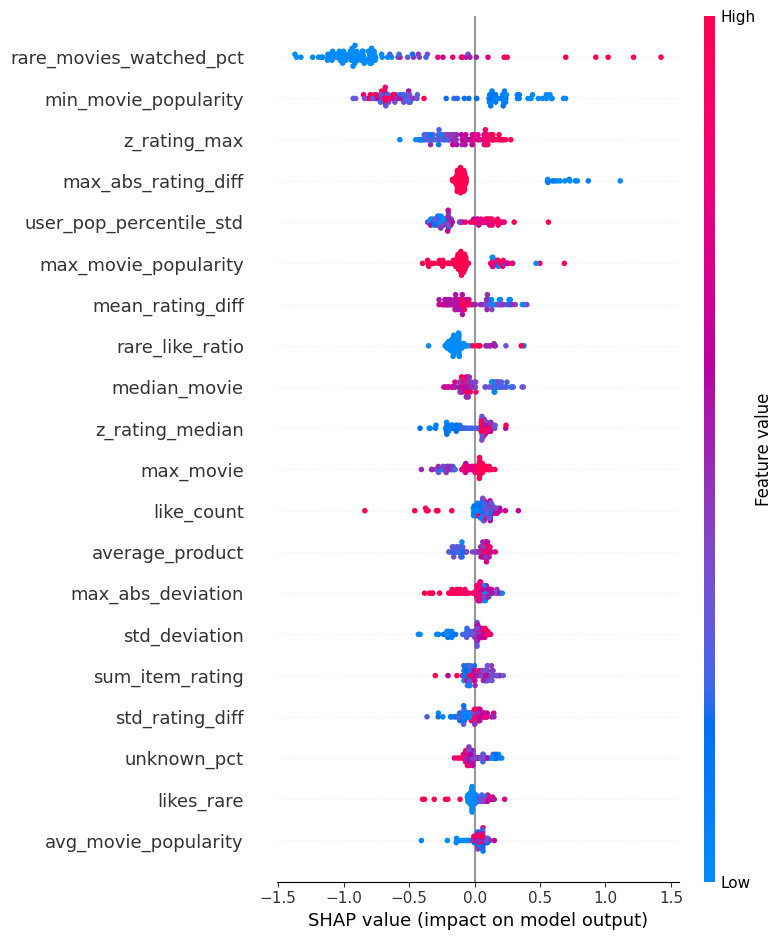

In [14]:
import shap

explainer = shap.TreeExplainer(xgb_model, X_train_poly)
shap_values = explainer(X_test_poly[:100], check_additivity=False)

shap_array = shap_values.values  # shape: (n_samples, n_features, n_classes)

# Loop over classes and show SHAP summary
for class_id in range(num_classes):
    print(f"\n📊 SHAP Summary for Class {class_id}")
    shap.summary_plot(
        shap_array[:, :, class_id],  # SHAP values for this class
        X_test_poly[:100],
        feature_names=model_features,
        show=True
    )
